# Importing Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from typing import Union
from tqdm import tqdm_notebook

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Read Data

In [2]:
df = pd.read_csv("AusAntidiabeticDrug.csv")
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [3]:
df["ds"] = pd.to_datetime(df["ds"])

# Visualization of the series

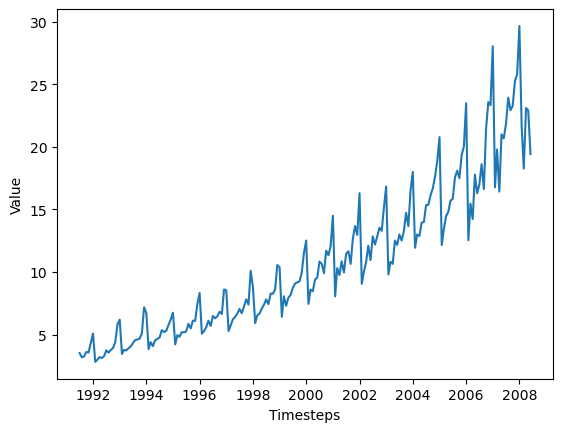

In [4]:
plt.plot(df["ds"],df["y"]);
plt.xlabel('Timesteps');
plt.ylabel('Value');

# there is clear trend and seasonality. We can see 12 month seasonality

# Decomposition

We can see seasonality and trend from decomposition

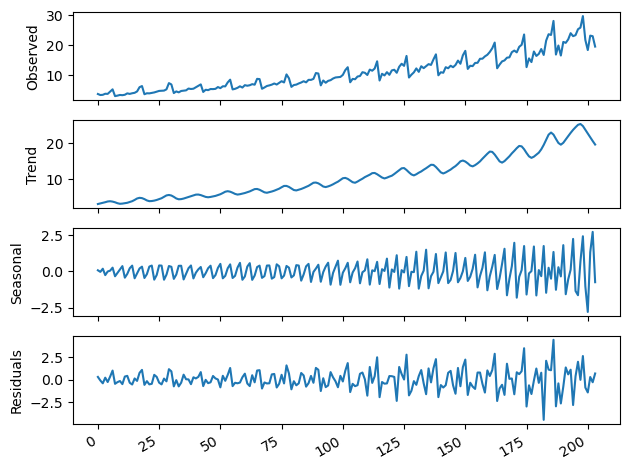

In [5]:
# Decomposition

advanced_decomposition = STL(df.y, period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

# Dickey-Adfuller Test

We apply this test to determine the data is stationary or non-stationary. If:
* p-value < 0.05 = data is stationary
* p-value > 0.05 = data is non-stationary

In [6]:
def adfuller_test(y):
    adf_result = adfuller(y)

    print("ADF Statistic:", adf_result[0])
    print("P-Value:", adf_result[1])

adfuller_test(df.y)
# data is non stationary

ADF Statistic: 3.145185689306742
P-Value: 1.0


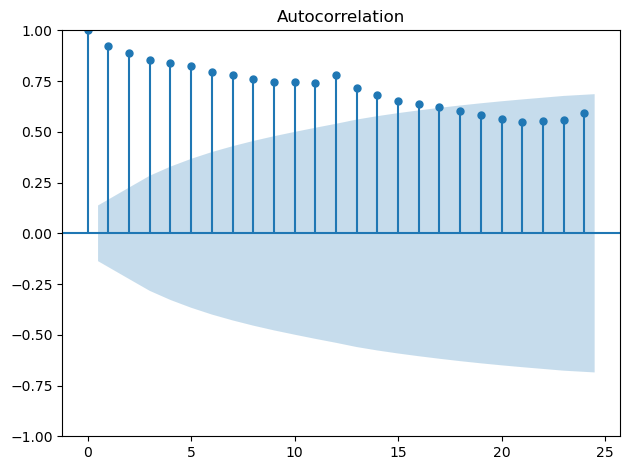

In [7]:
plot_acf(df.y)

plt.tight_layout()

We applied transormation to make data stationary and repeated the adfuller test

In [8]:
df_diff = np.diff(df.y, n=1)

In [9]:
adfuller_test(df_diff)

# still non-stationary

ADF Statistic: -2.4951721474496953
P-Value: 0.1166534168646986


We can see as a result of adfuller test p-value is greater than 0.05 so data is non-stationary and transformation did not work. Because of that we will apply second transformation. However now we will do this according to seasonality

In [10]:
df_diff2 = np.diff(df_diff, n=12)

In [11]:
adfuller_test(df_diff2)

# stationary

ADF Statistic: -19.84844009721397
P-Value: 0.0


After the second transformation when we applied adfuller test we can see p-value is not greater than 0.05 so we can reject null hypothesis and say data is stationary. 

Because of this transformations:
* d: 1
* D: 1

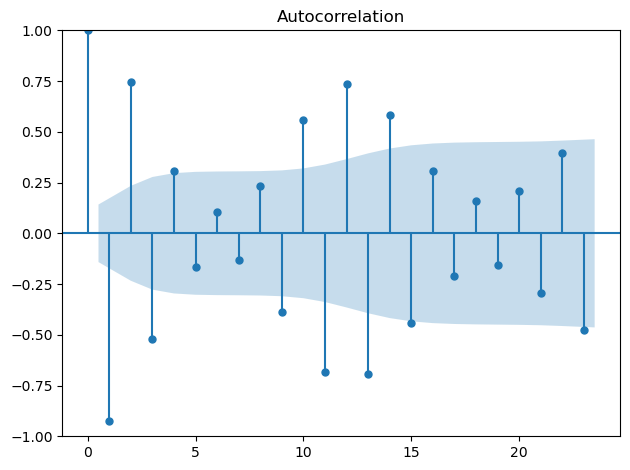

In [12]:
plot_acf(df_diff2)

plt.tight_layout()

In [46]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    # this function try combinations and give them with their AIC values
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [14]:
train = df[:168]
test = df[168:]

In [15]:
# combinations for all parameters
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12   # We have monthly data, so 12 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train['y'], SARIMA_order_list, d, D, s)

/var/folders/fx/sfm1r3x51czb__n2j19fryw00000gn/T/ipykernel_41396/3929307229.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/Users/busekoseoglu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/busekoseoglu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/busekoseoglu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/busekoseoglu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/busekoseoglu/opt/

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951097
1,"(3, 3, 1, 3)",271.457579
2,"(3, 2, 1, 3)",272.222636
3,"(3, 3, 0, 1)",272.580415
4,"(3, 3, 2, 0)",272.949438
...,...,...
250,"(0, 0, 3, 1)",351.425175
251,"(0, 0, 1, 1)",351.466837
252,"(0, 0, 0, 1)",354.751719
253,"(0, 0, 1, 0)",357.173706


In [47]:
# we choose the parameters with lowest AIC
SARIMA_result_df

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951097
1,"(3, 3, 1, 3)",271.457579
2,"(3, 2, 1, 3)",272.222636
3,"(3, 3, 0, 1)",272.580415
4,"(3, 3, 2, 0)",272.949438
...,...,...
250,"(0, 0, 3, 1)",351.425175
251,"(0, 0, 1, 1)",351.466837
252,"(0, 0, 0, 1)",354.751719
253,"(0, 0, 1, 0)",357.173706


In [16]:
# fitting the model with best params
SARIMA_model = SARIMAX(train['y'], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Thu, 06 Jul 2023   AIC                            270.951
Time:                                            21:58:08   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

* In the top left plot we can see the residuals have no trend over time and variance seems constant
* At the top right and left bottom we can see distributions of residulas are close to the normal distribution
* Finally in the correlogram we can see there is no significant coef

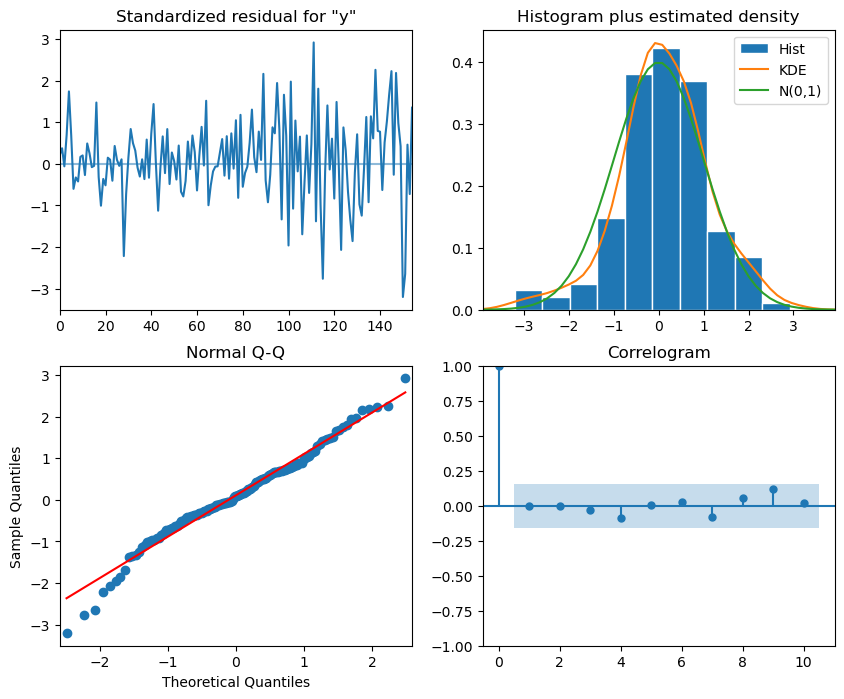

In [17]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [18]:
residuals = SARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.437102,0.508525
2,0.627725,0.730620
3,0.646153,0.885790
4,2.258368,0.688359
5,2.950633,0.707597
6,3.389565,0.758600
7,9.981778,0.189608
8,10.591869,0.225914
9,11.854042,0.221663
10,11.985269,0.286044


In [19]:
df.shape

(204, 2)

In [20]:
SARIMA_pred = SARIMA_model_fit.get_prediction(168, 204).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

/var/folders/fx/sfm1r3x51czb__n2j19fryw00000gn/T/ipykernel_41396/2455296028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


,ds,y,SARIMA_pred
168,2005-07-01,15.829550,16.745827
169,2005-08-01,17.554701,16.619269
170,2005-09-01,18.100864,17.255311
171,2005-10-01,17.496668,18.107488
172,2005-11-01,19.347265,18.722155
173,2005-12-01,20.031291,19.885851
174,2006-01-01,23.486694,22.216364
175,2006-02-01,12.536987,13.544376
176,2006-03-01,15.467018,14.972345
177,2006-04-01,14.233539,15.593429


In [21]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mape_SARIMA = mape(test['y'], test['SARIMA_pred'])

print(mape_SARIMA)

9.327457649796953


In [37]:
df = df.set_index("ds")
df

,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [38]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,1), seasonal_order=(1,1,3,12), simple_differencing=False)    # Set the right SARIMA parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2    # Use a window of 2, just like in chapter 6

pred_df = df[168:]

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last_value'] = pred_last_value
pred_df.loc[:, 'pred_SARIMA'] = pred_SARIMA

pred_df.head()


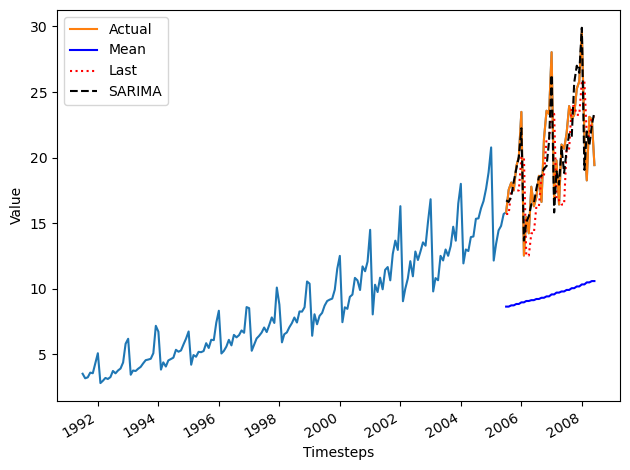

In [42]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df['y'], label='Actual')
ax.plot(pred_df['pred_mean'], 'b-', label='Mean')
ax.plot(pred_df['pred_last_value'], 'r:', label='Last')
ax.plot(pred_df['pred_SARIMA'], 'k--', label='SARIMA')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

ax.legend(loc='best')

#ax.axvspan(168, 204, color='#808080', alpha=0.2)

#plt.xlim(8000, 10000)
fig.autofmt_xdate()
plt.tight_layout()

127.07902984193957 9.238796907681897 3.100490965473368


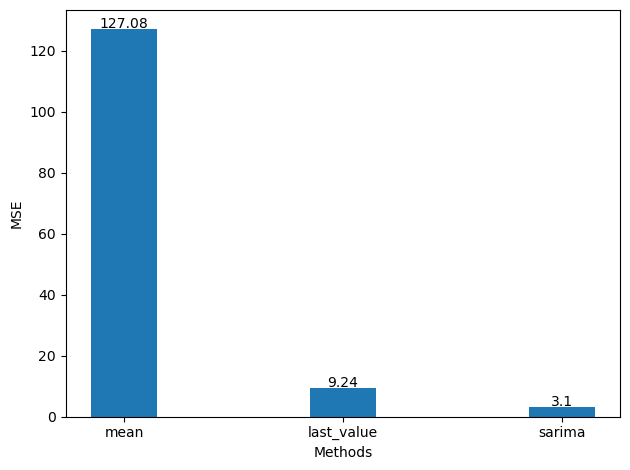

In [45]:
mse_mean = mean_squared_error(pred_df['y'], pred_mean)
mse_last = mean_squared_error(pred_df['y'], pred_last_value)
mse_sarima= mean_squared_error(pred_df['y'], pred_SARIMA)

print(mse_mean, mse_last, mse_sarima)

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'sarima']
y = [mse_mean, mse_last, mse_sarima]

ax.bar(x, y, width=0.3)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.5, s=str(round(value, 2)), ha='center')

plt.tight_layout()